# Car Price Prediction Project

#### Gerekli Kütüphanelerin Yüklenmesi (Importing Required Libraries)

In [985]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.model_selection import cross_val_score , train_test_split , GridSearchCV , ShuffleSplit

In [986]:
df = pd.read_csv("CarPrice_dataset.csv")
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


### Veri Temizleme (Data Wrangling)

In [987]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [988]:
#'?' stringleri varsa nan'a çevir
df = df.replace('?', np.nan)

In [989]:
# Eksik değer kontrolü
df.isnull().sum().sort_values()

car_ID              0
citympg             0
peakrpm             0
horsepower          0
compressionratio    0
stroke              0
boreratio           0
fuelsystem          0
enginesize          0
cylindernumber      0
enginetype          0
curbweight          0
carheight           0
carwidth            0
carlength           0
wheelbase           0
enginelocation      0
drivewheel          0
carbody             0
doornumber          0
aspiration          0
fueltype            0
CarName             0
symboling           0
highwaympg          0
price               0
dtype: int64

**tr:** Verimizde null değer olmadığını görüyoruz eğer olsaydı `fillna` fonksiyonu ile null degerleri manipüle etmemiz gerekirdi.  
**eng:** We see that there are no null values in our data. If there were, we would have needed to handle them using the `fillna` function

### Keşifsel veri analizi (EDA)

Text(0.5, 1.0, 'orjinal hali')

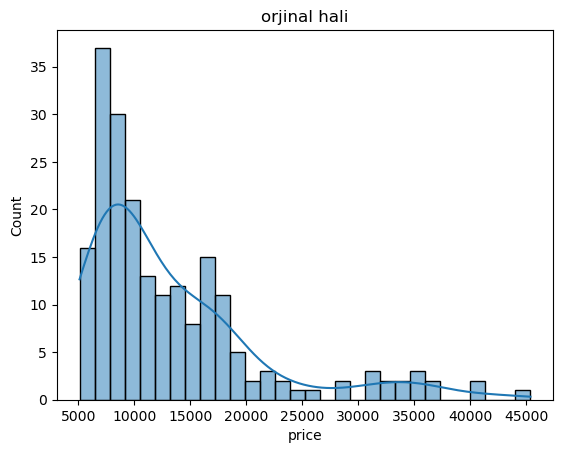

In [990]:
# price değişkeninin dağılımını inceleyelim
sns.histplot(df['price'], kde=True, bins=30)
plt.title('orjinal hali')

**tr:** Verinin sağa çarpık oldugunu görebiliyoruz bu yüzden logaritmik dönüüşümün nasıl etki ettiğine bakalım.  
**eng:** We can see that the data is right-skewed, so let's examine the effect of a logarithmic transformation.

Text(0.5, 0, 'log(fiyat)')

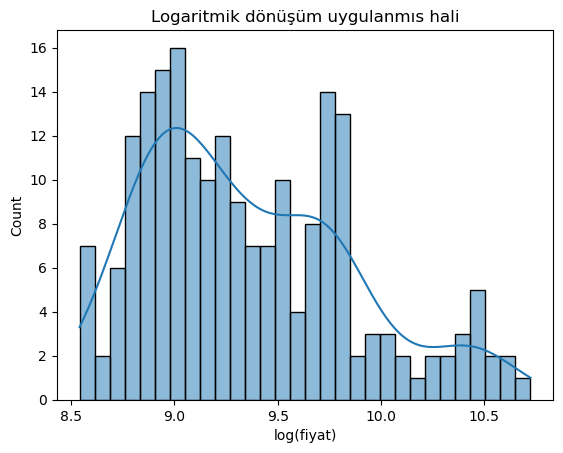

In [991]:
df['price'] = np.log1p(df['price'])
sns.histplot(df['price'], kde=True, bins=30)
plt.title('Logaritmik dönüşüm uygulanmıs hali')
plt.xlabel('log(fiyat)')

In [992]:
df['CarName']

0            alfa-romero giulia
1           alfa-romero stelvio
2      alfa-romero Quadrifoglio
3                   audi 100 ls
4                    audi 100ls
                 ...           
200             volvo 145e (sw)
201                 volvo 144ea
202                 volvo 244dl
203                   volvo 246
204                 volvo 264gl
Name: CarName, Length: 205, dtype: object

In [993]:
# CarName sütunundan marka bilgisini çıkaralım
df['brand'] = df['CarName'].apply(lambda x: x.split(' ')[0])
print(df['brand'].unique())
print("Toplam marka sayısı :", df['brand'].nunique())

['alfa-romero' 'audi' 'bmw' 'chevrolet' 'dodge' 'honda' 'isuzu' 'jaguar'
 'maxda' 'mazda' 'buick' 'mercury' 'mitsubishi' 'Nissan' 'nissan'
 'peugeot' 'plymouth' 'porsche' 'porcshce' 'renault' 'saab' 'subaru'
 'toyota' 'toyouta' 'vokswagen' 'volkswagen' 'vw' 'volvo']
Toplam marka sayısı : 28


**tr:** Çıktıyı incelediğimizde bazı tutarsızlıklar ve yazım hataları görüyoruz.  
**en:** When we examine the output, we see some inconsistencies and typos.
- maxda ve mazda
- Nissan ve nissan
- porsche ve porcshce 
- toyota ve toyouta 
- vokswagen, volkswagen ve vw

In [994]:
df['brand'] = df['brand'].replace({'maxda': 'mazda',
    'porcshce':'porsche',
    'toyouta':'toyota',
    'vokswagen':'volkswagen',
    'vw':'volkswagen',
    'Nissan':'nissan'})

print("düzeltme sonrası marka sayısı :", df['brand'].nunique())
print(df['brand'].unique())

düzeltme sonrası marka sayısı : 22
['alfa-romero' 'audi' 'bmw' 'chevrolet' 'dodge' 'honda' 'isuzu' 'jaguar'
 'mazda' 'buick' 'mercury' 'mitsubishi' 'nissan' 'peugeot' 'plymouth'
 'porsche' 'renault' 'saab' 'subaru' 'toyota' 'volkswagen' 'volvo']


Text(0, 0.5, 'Ortalama fiyat')

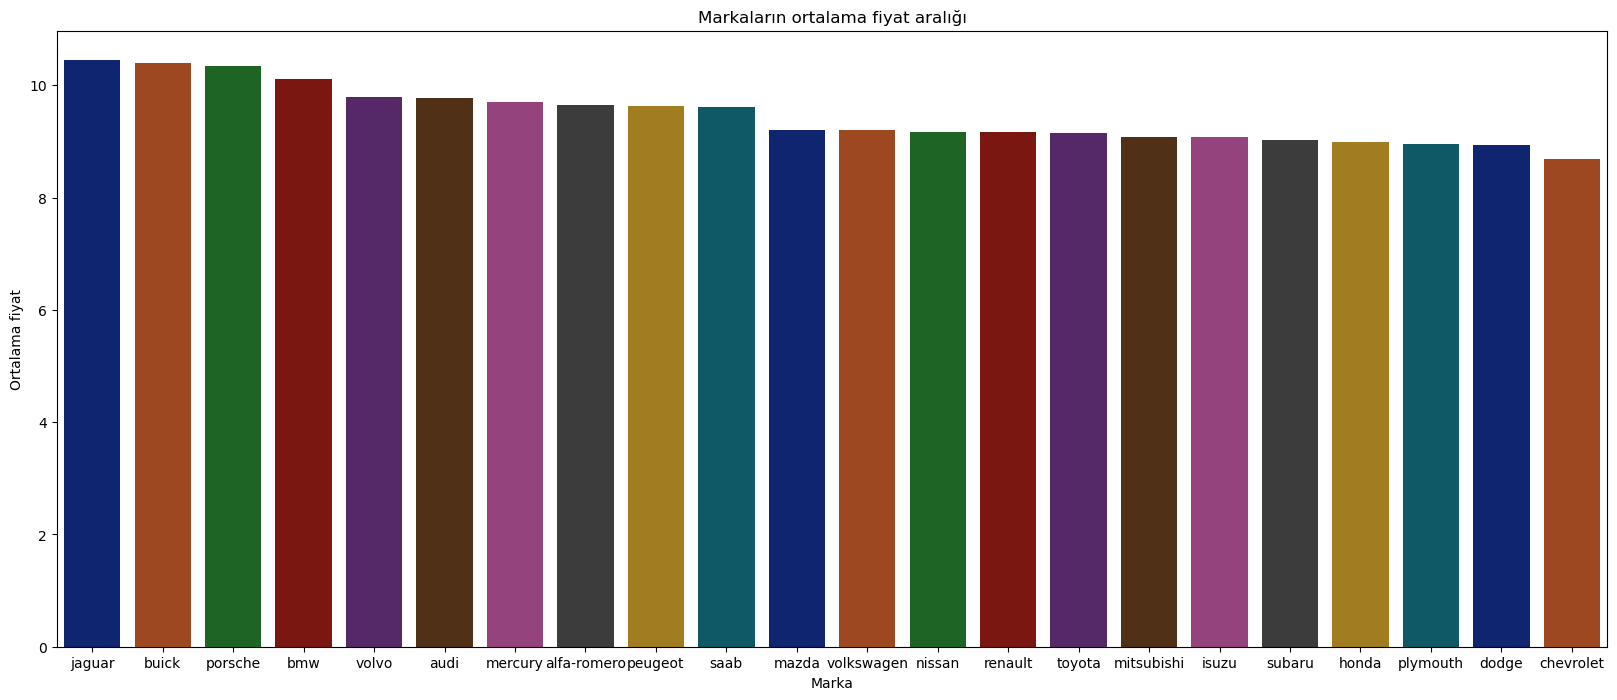

In [995]:
brand_prices = df.groupby('brand')['price'].mean().sort_values(ascending=False) # series döndürüyor index = brand , values = price
plt.figure(figsize=(20, 8))
sns.barplot(x=brand_prices.index, y=brand_prices.values,hue=brand_prices.index,palette='dark')
plt.title('Markaların ortalama fiyat aralığı')
plt.xlabel('Marka')
plt.ylabel('Ortalama fiyat')

In [996]:
# Verilerin price ile olan bagıntısını görmek için korelasyonu görünteleyelim
numerical_df = df.select_dtypes(include=np.number) # sadece sayısal sütunları içeriyor
numerical_df.corr()['price']

car_ID             -0.044496
symboling          -0.088716
wheelbase           0.629399
carlength           0.767859
carwidth            0.802544
carheight           0.162795
curbweight          0.891235
enginesize          0.831990
boreratio           0.610563
stroke              0.097990
compressionratio    0.085143
horsepower          0.825836
peakrpm            -0.088454
citympg            -0.771611
highwaympg         -0.775193
price               1.000000
Name: price, dtype: float64

**tr:** Verilerin birbiri ile olan korelasyonunu görselleştirelim.  
**eng:** Let's visualize the correlation between the features.

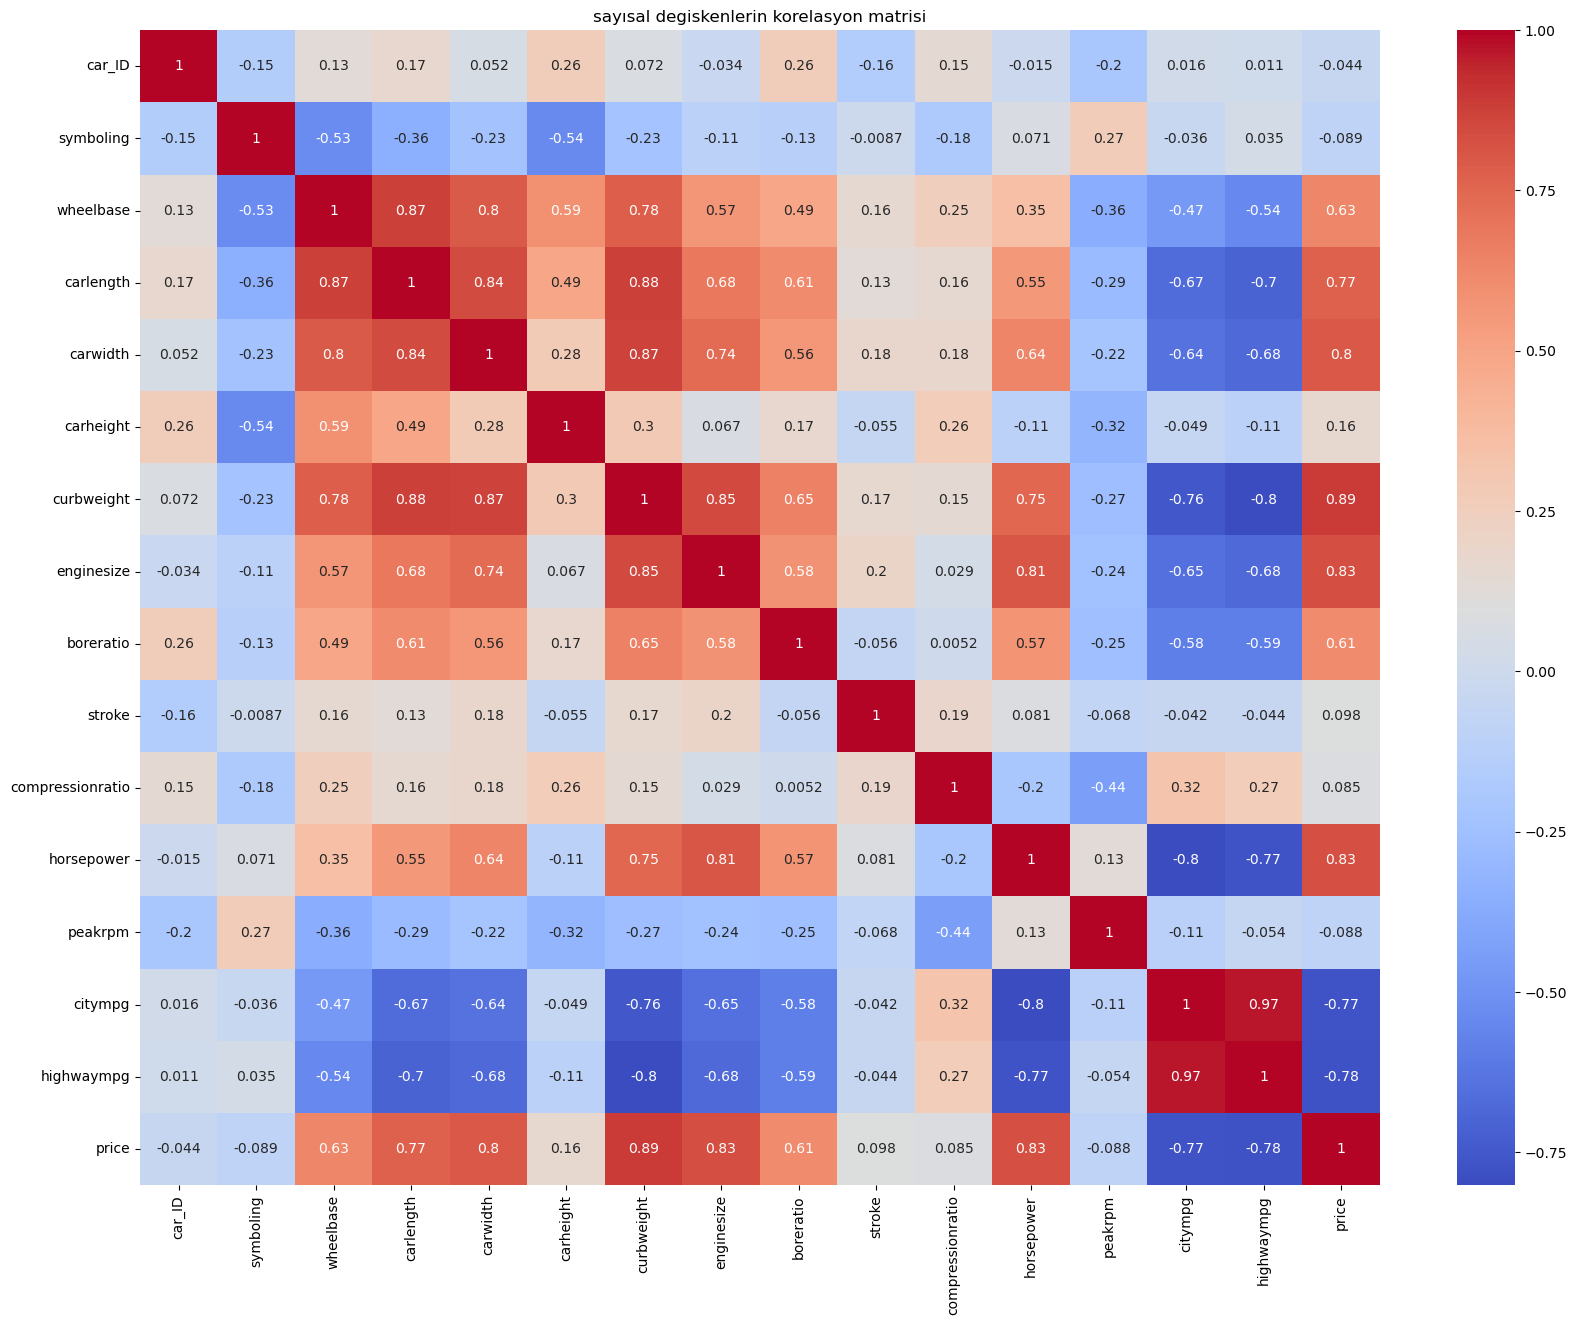

In [997]:
plt.figure(figsize=(20,15))
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm')
plt.title('sayısal degiskenlerin korelasyon matrisi')
plt.show()

**Not:** 0.8'in üzerindeki korelasyonlar yüksek ilişkiyi gösterir(Price ile olan korelasyonlar haric).Overfitting’i önlemek amacıyla bu değişkenlere feature engineering yapmalıyız.  
**Note:** Correlations above 0.8 indicate a high relationship (excluding correlations with 'price'). To prevent overfitting, we should apply feature engineering to these variables.

In [998]:
# 0.84 korelasyona sahip ve benze islevleri olan carwidth ve carlength oranlarını tek bir sütuna atıyoruz
df['width_length_ratio'] = df['carwidth'] / df['carlength']
df = df.drop(['carwidth', 'carlength'], axis=1)

# Aynı sekilde city_mpg ve highway_mpg neredeyse birebir aynı 0.97 korelasyon çok yüksek bu yüzden ortalamalarını yeni bir sütuna ekliyoruz
df['avg_mpg'] = (df['citympg'] + df['highwaympg']) / 2
df = df.drop(['citympg', 'highwaympg'], axis=1)

# curbweight, horsepower ve enginesize ise aralarındaki yüksek korelasyona rağmen tutuyoruz cünkü price ile cok güclü bir korelasyona sahiplerve bu üç sütunu tek bir sütunda toplamak olası değil veriyi kaybetmemek adına bu bu sütunlara işlem yapmıyoruz veya silmiyoruz.


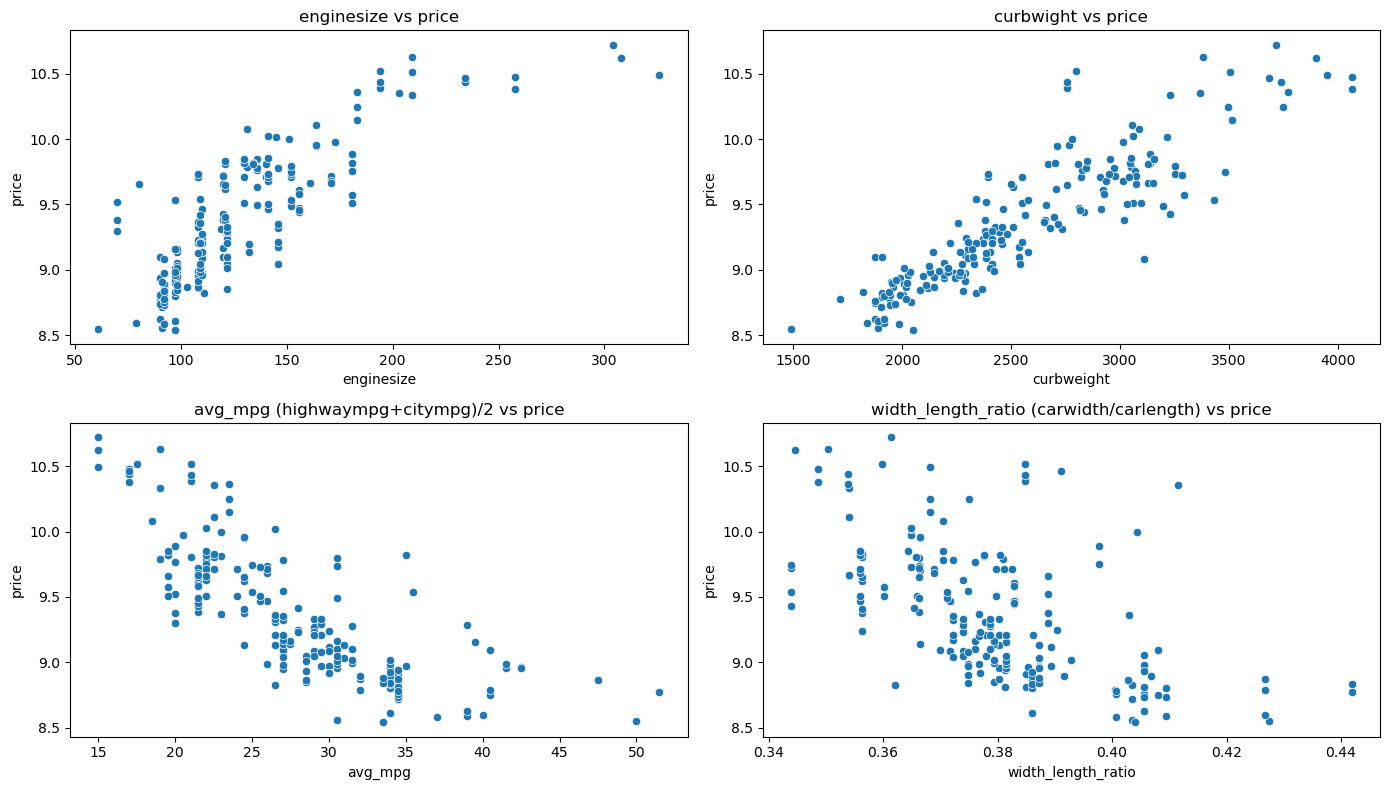

In [999]:
plt.figure(figsize=(14,8))
plt.subplot(2, 2,1)
sns.scatterplot(x=df['enginesize'], y=df['price'])
plt.title('enginesize vs price')

plt.subplot(2,2,2)
sns.scatterplot(x=df['curbweight'],y=df['price'])
plt.title('curbwight vs price')
plt.subplot(2, 2,3)
sns.scatterplot(x=df['avg_mpg'], y=df['price'])
plt.title('avg_mpg (highwaympg+citympg)/2 vs price')

plt.subplot(2, 2,4)
sns.scatterplot(x=df['width_length_ratio'], y=df['price'])
plt.title('width_length_ratio (carwidth/carlength) vs price')

plt.tight_layout()
plt.show()

In [1000]:
# kategorik değişkenleri sayısal değişkenlere çevirelim
df = pd.get_dummies(df, columns=['drivewheel', 'fueltype', 'carbody', 'enginetype', 'brand'], drop_first=True)

In [1001]:
# işimize yaramayan CarName sütununu ve korelasyon analizinde düşük ilişki gösteren sütunları silelim 
# carlength, carwidth,citympg,highwaympg ve horsepower ı zaten yukarıda sildik
df = df.drop(columns=['CarName', 'car_ID', 'symboling', 'aspiration', 'doornumber', 'enginelocation', 'wheelbase',  'carheight','cylindernumber',
                      'fuelsystem', 'boreratio', 'stroke', 'compressionratio', 'peakrpm'])
df.head()

,curbweight,enginesize,horsepower,price,width_length_ratio,avg_mpg,drivewheel_fwd,drivewheel_rwd,fueltype_gas,carbody_hardtop,...,brand_nissan,brand_peugeot,brand_plymouth,brand_porsche,brand_renault,brand_saab,brand_subaru,brand_toyota,brand_volkswagen,brand_volvo
0,2548,130,111,9.510149,0.379739,24.0,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,2548,130,111,9.711176,0.379739,24.0,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
2,2823,152,154,9.711176,0.382593,22.5,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
3,2337,109,102,9.543306,0.374858,27.0,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,2824,136,115,9.767152,0.375991,20.0,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


### Model Geliştirme (Model Evaluation)

In [1002]:
X = df.drop(['price'],axis=1)
Y = df['price']
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=0) # %80 train %20 test şeklinde verimizi bölüyoruz

##### Linear Regresyon (Linear Regression)

In [1003]:
lr = LinearRegression()
lr.fit(x_train,y_train)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
scores = cross_val_score(lr, X, Y, cv=cv, scoring='r2')
y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

# mean_squared_error ile dogrulugunu test edelim
mse_train = mean_squared_error(y_train,y_train_pred)
mse_test = mean_squared_error(y_test,y_test_pred)
print("Linear Regresyon R2 skorları:", scores)
print("Ortalama R2:", scores.mean())
print("MSE train :",mse_train,"\nMSE test :",mse_test)

Linear Regresyon R2 skorları: [0.8527693  0.91644741 0.94009838 0.92080583 0.93709866 0.82819824
 0.89533612 0.88074614 0.88986117 0.93639117]
Ortalama R2: 0.8997752403317125
MSE train : 0.00994276313275782 
MSE test : 0.04202267130444943


### Model İyileştirme (Model improvement)

##### Polynomial / StandardScaler / Ridge Regression 

In [1004]:
Input = [('poly',PolynomialFeatures(degree=2)),
        ('scaler',StandardScaler()),
        ('ridge',Ridge())]
pipe = Pipeline(Input)

# degree parametresi ve alpha parametresi için denenecek değerler
params = {'poly__degree':[1,2,3],'ridge__alpha':[0.01, 0.1, 1, 10, 100]  }

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=1)
grid = GridSearchCV(pipe, params, cv=cv, scoring='r2')
grid.fit(x_train, y_train)
y_train_pred1 = grid.predict(x_train)
y_test_pred1 = grid.predict(x_test)
mse_train2 = mean_squared_error(y_train, y_train_pred1)
mse_test2 = mean_squared_error(y_test, y_test_pred1)

scores_ridge = cross_val_score(pipe, X, Y, cv=cv, scoring='r2')

print("Ridge R^2 skorları :", scores_ridge)
print("Ortalama Ridge R^2 :", scores_ridge.mean())
print("Test seti R^2 :", r2_score(y_test, y_test_pred1))
print("En iyi parametreler:", grid.best_params_)
print("Val_R2 :", grid.best_score_)
print("MSE Train :", mse_train)
print("MSE Test  :", mse_test)

Ridge R^2 skorları : [0.93362161 0.93379279 0.92262657 0.95708298 0.91855652 0.95165823
 0.94972208 0.8969216  0.93947594 0.91408545]
Ortalama Ridge R^2 : 0.9317543769829703
Test seti R^2 : 0.8643040224289265
En iyi parametreler: {'poly__degree': 1, 'ridge__alpha': 10}
Val_R2 : 0.9133066704492496
MSE Train : 0.00994276313275782
MSE Test  : 0.04202267130444943


### Model Değerlendirme ve Görselleştirme (Model Evaluation and Visualization)

###### Linear Regresyon için (For Linear Regression) :

Text(0.5, 1.0, 'Gerçek vs Tahmin')

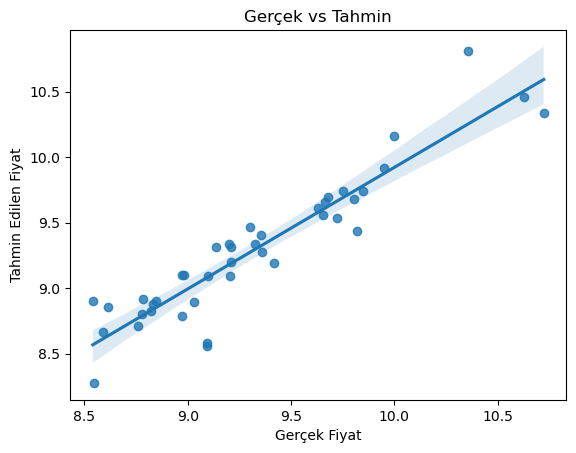

In [1005]:
sns.regplot(x=y_test, y=y_test_pred)
plt.xlabel("Gerçek Fiyat")
plt.ylabel("Tahmin Edilen Fiyat")
plt.title("Gerçek vs Tahmin")

###### Ridge için (For ridge) : 

Text(0.5, 1.0, 'Gerçek vs Tahmin')

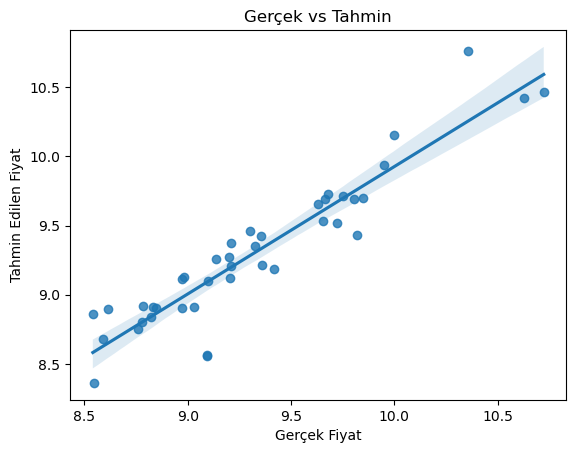

In [1006]:
sns.regplot(x=y_test, y=y_test_pred1)
plt.xlabel("Gerçek Fiyat")
plt.ylabel("Tahmin Edilen Fiyat")
plt.title("Gerçek vs Tahmin")

##### Sonucların görselleştirilmesi (Visualization of Results)

In [1007]:
results = {
    "Model": ["Linear Regression", "Ridge Regression"],
    "Train MSE": [mse_train, mse_train2],  
    "Test MSE": [mse_test, mse_test2],
    "CV R^2": [scores.mean(), scores_ridge.mean()],
    "Best Alpha": [None, grid.best_params_]
}
results_df = pd.DataFrame(results)
display(results_df)

,Model,Train MSE,Test MSE,CV R^2,Best Alpha
0,Linear Regression,0.009943,0.042023,0.899775,None
1,Ridge Regression,0.011264,0.038730,0.931754,"{'poly__degree': 1, 'ridge__alpha': 10}"


##### Linear model için residual plot (Residual Plot for Linear Model) :

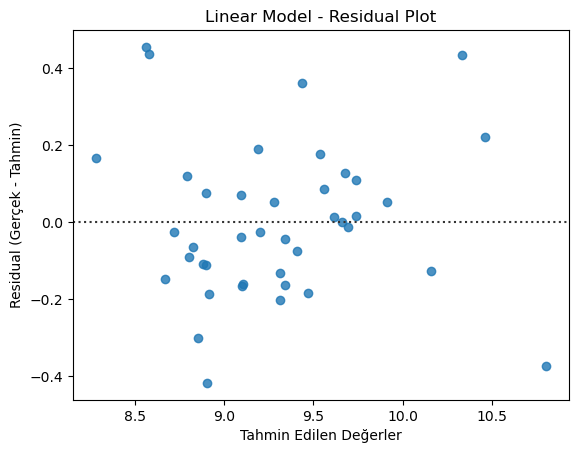

In [1008]:
sns.residplot(x=y_test_pred, y=y_test)
plt.xlabel("Tahmin Edilen Değerler")
plt.ylabel("Residual (Gerçek - Tahmin)")
plt.title("Linear Model - Residual Plot")
plt.show()

##### Ridge model için residual plot (Residual Plot for Ridge Model) :

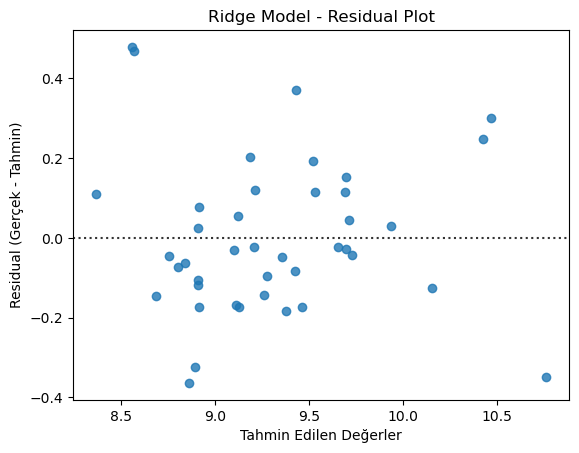

In [1009]:
sns.residplot(x=y_test_pred1, y=y_test)
plt.xlabel("Tahmin Edilen Değerler")
plt.ylabel("Residual (Gerçek - Tahmin)")
plt.title("Ridge Model - Residual Plot")
plt.show()

#### İletişim / Contact  
*Ebubekir Kartal*
*  [GitHub](https://github.com/Kartal-Ebubekir)
*  [LinkedIn](https://www.linkedin.com/in/ebubekir-kartal-645091335/)